Name: Boga Petruska\
Class: ECBS5171 - Data Analysis 3\
Assignment: Assignment 1\
Date: Feb 2, 2026

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
import time
import warnings
import ast
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from collections import Counter
import shap

# Set display options
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 10)

## Part I: Modeling

### 1. Data Wrangling

In [4]:
def wrangle_airbnb_data(df_raw, price_upper_bound=None, amenities_list=None):
    """
    Parameters:
    - df_raw: Raw dataframe
    - price_upper_bound: Cap for outliers (None = calculate 99th pct)
    - amenities_list: Fixed list of amenities to extract (None = calculate from data)
    
    Returns:
    - df: Cleaned dataframe
    - amenities_list: List used (saved from training to reuse)
    """
    df = df_raw.copy()
    
    # 1. Select columns to keep
        # selected based on domain knowledge for features that will likely influence price; 
        # categories of retained columns indicated below 
    cols_to_keep = [
        'id',
        'price', 
        # characteristics of property
        'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
        # location, location, location
        'neighbourhood_cleansed', 'latitude', 'longitude',
        # host info
        'host_is_superhost', 'host_response_rate', 'host_acceptance_rate',
        'host_listings_count', 'host_identity_verified',
        # review info
        'number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness',
        'review_scores_location', 'review_scores_value', 'reviews_per_month',
        # availability stats
        'availability_30', 'availability_365', 'instant_bookable',
        'minimum_nights', 'maximum_nights',
        # Amenities (raw - will need to extract)
        'amenities'
    ]

    # Keep only selected columns that exist in the dataset
    cols_available = [c for c in cols_to_keep if c in df_raw.columns]
    df= df_raw[cols_available].copy()


    # 2. clean price: remove $ and commas, convert to float
    df['price'] = (
        df['price'].astype(str)
        .str.replace('$', '', regex=False)
        .str.replace(',', '', regex=False)
        .astype(float)
    )
    if price_upper_bound is None:
        price_upper_bound = df['price'].quantile(0.99)
    df = df[(df['price'] > 0) & (df['price'] <= price_upper_bound)].copy()
    
    # 3. Extract amenities

    # Convert to lowercase string for matching
    df['amenities'] = df['amenities'].fillna('').astype(str).str.lower()
    
    # If no list provided, calculate from this data (training mode)
    if amenities_list is None:
        from collections import Counter

        # Count frequency of each amenity
        all_amenities = []
        for row in df['amenities']:
            items = [x.strip().strip('"').strip("'").strip('[').strip(']') for x in row.split(',')]
            items = [x for x in items if x] # remove empty strings
            all_amenities.extend(items)
        
        amenity_freq = Counter(all_amenities)
        n_listings = len(df)
        
        amenities_mid_freq = [
            amenity for amenity, count in amenity_freq.items()
            if 0.30 <= count / n_listings <= 0.70
        ]
        # Manual additions: premium amenities based on domain knowledge of staying in hotels/Airbnbs
        amenities_premium = [
            'pool', 'hot tub', 'gym', 'air conditioning', 'washer', 'dryer',
            'ev charger', 'waterfront', 'ocean view'
        ]
        amenities_list = list(set(amenities_mid_freq + amenities_premium))
    
    # Create binary indicators using the fixed list
    for amenity in amenities_list:
        col_name = amenity.replace(' ', '_').replace('-', '_').replace('–', '_')
        col_name = ''.join(c for c in col_name if c.isalnum() or c == '_')
        col_name = f"amenity_{col_name}"
        df[col_name] = df['amenities'].str.contains(amenity, regex=False).astype(int)

    # Total amenities score
    amenity_cols = [c for c in df.columns if c.startswith('amenity_')]
    df['amenities_score'] = df[amenity_cols].sum(axis=1)
    
    # Drop raw amenities column
    df = df.drop(columns=['amenities'])

    # 4. Extract bathrooms
    def extract_bathrooms(text):
        if pd.isna(text):
            return np.nan
        text = str(text).lower()
        match = re.search(r'(\d+\.?\d*)', text)
        if match:
            return float(match.group(1))
        if 'half' in text:
            return 0.5
        return np.nan
    
    df['bathrooms'] = df['bathrooms_text'].apply(extract_bathrooms)
    df = df.drop(columns=['bathrooms_text'])

    # 5. Clean percentages
    for col in ['host_response_rate', 'host_acceptance_rate']:
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                .str.replace('%', '', regex=False)
                .str.replace('nan', '', regex=False)
                .str.replace('N/A', '', regex=False)
                .replace('', np.nan)
                .astype(float)
            )

     # 6. superhost columns converted boolean columns
    for col in ['host_is_superhost', 'host_identity_verified', 'instant_bookable']:
        if col in df.columns:
            df[col] = df[col].map({'t': 1, 'f': 0, True: 1, False: 0}).fillna(0).astype(int)
    
    # 7. Simplify property type
    top_types = df['property_type'].value_counts().head(10).index.tolist()
    df['property_type_clean'] = df['property_type'].apply(lambda x: x if x in top_types else 'Other')
    df = df.drop(columns=['property_type'])
    
    # 8. Impute missing values with median
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())   
    
    return df, amenities_list

In [5]:
# load case dataset: airbnb San Diego Q4 2024
df_raw = pd.read_csv('../data/San Diego 2024 Q4 listings.csv')
print(f"Raw data shape: {df_raw.shape}")
df_raw.head()

Raw data shape: (12844, 75)


,id,listing_url,scrape_id,last_scraped,source,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6,https://www.airbnb.com/rooms/6,20241223022521,2024-12-23,city scrape,...,1,1,0,0,0.82
1,12447,https://www.airbnb.com/rooms/12447,20241223022521,2024-12-23,city scrape,...,2,0,2,0,0.03
2,29967,https://www.airbnb.com/rooms/29967,20241223022521,2024-12-23,city scrape,...,5,5,0,0,0.65
3,54001,https://www.airbnb.com/rooms/54001,20241223022521,2024-12-23,city scrape,...,2,1,1,0,2.03
4,62274,https://www.airbnb.com/rooms/62274,20241223022521,2024-12-23,city scrape,...,2,0,2,0,5.45


In [6]:
# check data types and missing values
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12844 non-null  int64  
 1   listing_url                                   12844 non-null  object 
 2   scrape_id                                     12844 non-null  int64  
 3   last_scraped                                  12844 non-null  object 
 4   source                                        12844 non-null  object 
 5   name                                          12844 non-null  object 
 6   description                                   12638 non-null  object 
 7   neighborhood_overview                         8046 non-null   object 
 8   picture_url                                   12844 non-null  object 
 9   host_id                                       12844 non-null 

In [7]:
df_train, amenities_list = wrangle_airbnb_data(df_raw)
price_upper_bound = df_train['price'].max()

In [8]:
print(f"Shape: {df_train.shape}")
print(f"Amenities extracted: {len(amenities_list)}")
df_train.head()

Shape: (11543, 73)
Amenities extracted: 46


,id,price,room_type,accommodates,bedrooms,...,amenity_freezer,amenity_exterior_security_cameras_on_property,amenities_score,bathrooms,property_type_clean
0,6,249.0,Entire home/apt,8,3.0,...,1,1,37,2.0,Entire home
1,12447,87.0,Private room,2,1.0,...,0,0,12,1.0,Other
2,29967,268.0,Entire home/apt,6,2.0,...,0,0,8,2.0,Other
3,54001,159.0,Entire home/apt,2,2.0,...,1,0,26,1.0,Entire guesthouse
4,62274,91.0,Private room,2,1.0,...,0,0,17,1.0,Private room in home


#### Create Dummy Variables for Categoricals

In [9]:
# Create dummies for categorical variables
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()
df_train_model = pd.get_dummies(df_train, columns=cat_cols, drop_first=True)

# Convert bool to int
bool_cols = df_train_model.select_dtypes(include=['bool']).columns
df_train_model[bool_cols] = df_train_model[bool_cols].astype(int)

print(f"Shape: {df_train_model.shape}")

Shape: (11543, 183)


In [10]:
# Summary of final dataset
print("Final dataset info:")
print(f"  Rows: {len(df_train_model)}")
print(f"  Features: {len(df_train_model.columns) - 2} (excluding id and price)")
print(f"  Target (price) range: ${df_train_model['price'].min():.0f} - ${df_train_model['price'].max():.0f}")
print(f"  Target (price) mean: ${df_train_model['price'].mean():.2f}")



Final dataset info:
  Rows: 11543
  Features: 181 (excluding id and price)
  Target (price) range: $25 - $2000
  Target (price) mean: $287.18


---

### 2. Build 5 Predictive Models

In [11]:
# Prepare features and target
X = df_train_model.drop(columns=['id', 'price'])
y = df_train_model['price']

# Train-test split
# 80/20 split: train on 80%, evaluate on held-back 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training: {len(X_train)} rows")
print(f"Test: {len(X_test)} rows")
print(f"Features: {X_train.shape[1]}")

Training: 9234 rows
Test: 2309 rows
Features: 181


In [12]:
# Model a: OLS (Linear Regression)

print("Training OLS...")
start = time.time()

ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)

time_ols = time.time() - start

print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_ols)):.2f}")
print(f"  MAE: ${mean_absolute_error(y_test, y_pred_ols):.2f}")
print(f"  R²: {r2_score(y_test, y_pred_ols):.4f}")
print(f"  Time: {time_ols:.2f}s")

Training OLS...
  RMSE: $171.43
  MAE: $107.42
  R²: 0.6273
  Time: 0.10s


In [13]:
# Model b: LASSO

print("Training LASSO...")
start = time.time()

# Scale features - standardize features for LASSO 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit LASSO with fixed alpha
lasso = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

time_lasso = time.time() - start

print(f"  Non-zero coefficients: {np.sum(lasso.coef_ != 0)} / {len(lasso.coef_)}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.2f}")
print(f"  MAE: ${mean_absolute_error(y_test, y_pred_lasso):.2f}")
print(f"  R²: {r2_score(y_test, y_pred_lasso):.4f}")
print(f"  Time: {time_lasso:.2f}s")

Training LASSO...
  Non-zero coefficients: 173 / 181
  RMSE: $171.48
  MAE: $107.27
  R²: 0.6271
  Time: 0.12s


In [14]:
# Model c: Random Forest

print("Training Random Forest...")
start = time.time()

# Using 500 trees for better performance (default is 100)
rf = RandomForestRegressor(n_estimators=500, random_state=42)  # default is 100
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

time_rf = time.time() - start

print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"  MAE: ${mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"  R²: {r2_score(y_test, y_pred_rf):.4f}")
print(f"  Time: {time_rf:.2f}s")


Training Random Forest...
  RMSE: $156.32
  MAE: $85.90
  R²: 0.6901
  Time: 64.62s


In [15]:
# Model d: Boosting of my Choice - Gradient Boosting

print("Training Gradient Boosting...")
start = time.time()

# Using 500 trees for better performance (default is 100)
gbm = GradientBoostingRegressor(n_estimators=500, random_state=42)  
gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)

time_gbm = time.time() - start

print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_gbm)):.2f}")
print(f"  MAE: ${mean_absolute_error(y_test, y_pred_gbm):.2f}")
print(f"  R²: {r2_score(y_test, y_pred_gbm):.4f}")
print(f"  Time: {time_gbm:.2f}s")

Training Gradient Boosting...
  RMSE: $150.42
  MAE: $85.24
  R²: 0.7130
  Time: 15.36s


In [16]:
# Model e: Something else of your choice - XGBoost

print("Training XGBoost...")
start = time.time()

# Using 500 trees for better performance (default is 100)
xgb_model = XGBRegressor(n_estimators=500, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

time_xgb = time.time() - start

print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"  MAE: ${mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"  R²: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"  Time: {time_xgb:.2f}s")

Training XGBoost...
  RMSE: $158.54
  MAE: $87.53
  R²: 0.6812
  Time: 0.95s


---

### 3. Horserace Table

In [17]:
# Store results for horserace table
results = {
    'OLS': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ols)),
        'MAE': mean_absolute_error(y_test, y_pred_ols),
        'R2': r2_score(y_test, y_pred_ols),
        'Time': time_ols
    },
    'LASSO': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
        'MAE': mean_absolute_error(y_test, y_pred_lasso),
        'R2': r2_score(y_test, y_pred_lasso),
        'Time': time_lasso
    },
    'Random Forest': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        'MAE': mean_absolute_error(y_test, y_pred_rf),
        'R2': r2_score(y_test, y_pred_rf),
        'Time': time_rf
    },
    'Gradient Boosting': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gbm)),
        'MAE': mean_absolute_error(y_test, y_pred_gbm),
        'R2': r2_score(y_test, y_pred_gbm),
        'Time': time_gbm
    },
    'XGBoost': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'MAE': mean_absolute_error(y_test, y_pred_xgb),
        'R2': r2_score(y_test, y_pred_xgb),
        'Time': time_xgb
    }
}

# Create horserace table
horserace = pd.DataFrame(results).T
horserace = horserace.round({'RMSE': 2, 'MAE': 2, 'R2': 4, 'Time': 2})
horserace = horserace.sort_values('RMSE')

print("=" * 60)
print("HORSERACE TABLE: Model Comparison (San Diego Q4 2024)")
print("=" * 60)
print(horserace.to_string())
print("=" * 60)

HORSERACE TABLE: Model Comparison (San Diego Q4 2024)
                     RMSE     MAE      R2   Time
Gradient Boosting  150.42   85.24  0.7130  15.36
Random Forest      156.32   85.90  0.6901  64.62
XGBoost            158.54   87.53  0.6812   0.95
OLS                171.43  107.42  0.6273   0.10
LASSO              171.48  107.27  0.6271   0.12


#### Performance Discussion
Based on compilation in table above

- Random Forest, XGBoost, Gradient Boosting (all tree-based ensemble methods) collectively outperform linear models (OLS, LASSO) by ~$13-22 RMSE
- Gradient Boosting achieves best fit (R^2 = 0.72) with 500 trees
- XGBoost offers best speed/accuracy tradeoff - reasonable R^2 (0.68) but 65x faster than Random Forest
- OLS and LASSO perform nearly identically. This suggests that regularization doesn't help much here (most features contribute to prediction)
- Reviewing R² values, tree models explain ~68-72% of price variance vs ~63% for linear models - remaining variance likely due to unobserved factors (such as photo quality, description text, etc.)


---

### 4. Analyze two models (RF and a boosting model)
- Show feature importance. 
- Compare the 10 most important features. 
- Discuss your findings. 


In [18]:
# feature importance - Random Forest
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)


# Feature importance - Gradient Boosting
gbm_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gbm.feature_importances_
}).sort_values('importance', ascending=False)


In [19]:
# Side-by-side top 20 features comparison of Random Forest and Gradient Boosting
comparison = pd.DataFrame({
    'RF_Rank': range(1, 21),
    'RF_Feature': rf_importance.head(20)['feature'].values,
    'RF_Importance': (rf_importance.head(20)['importance'].values * 100).round(2),
    'GBM_Rank': range(1, 21),
    'GBM_Feature': gbm_importance.head(20)['feature'].values,
    'GBM_Importance': (gbm_importance.head(20)['importance'].values * 100).round(2),
})

comparison['RF_Importance'] = comparison['RF_Importance'].astype(str) + '%'
comparison['GBM_Importance'] = comparison['GBM_Importance'].astype(str) + '%'

print("=" * 100)
print("Feature Importance: Random Forest vs Gradient Boosting (Top 20)")
print("=" * 100)
print(comparison.to_string(index=False))
print("=" * 100)

Feature Importance: Random Forest vs Gradient Boosting (Top 20)
 RF_Rank                        RF_Feature RF_Importance  GBM_Rank                       GBM_Feature GBM_Importance
       1                         bathrooms        27.32%         1                         bathrooms         29.92%
       2                      accommodates        25.48%         2                      accommodates         25.08%
       3                         longitude         8.09%         3                          bedrooms          9.71%
       4                          bedrooms         3.28%         4                         longitude          8.77%
       5               host_listings_count         2.63%         5               host_listings_count          4.18%
       6                   amenities_score         2.16%         6                              beds          1.58%
       7                  availability_365          2.1%         7 property_type_clean_Room in hotel          1.49%
       8

In [20]:
# Compare top 10 features between RF and GBM
rf_top10 = set(rf_importance.head(10)['feature'])
gbm_top10 = set(gbm_importance.head(10)['feature'])

print("Feature Importance Comparison (Top 10):")
print(f"\nIn BOTH top 10: {rf_top10 & gbm_top10}")
print(f"\nOnly in RF top 10: {rf_top10 - gbm_top10}")
print(f"\nOnly in GBM top 10: {gbm_top10 - rf_top10}")

Feature Importance Comparison (Top 10):

In BOTH top 10: {'longitude', 'reviews_per_month', 'property_type_clean_Room in hotel', 'bathrooms', 'amenities_score', 'host_listings_count', 'bedrooms', 'accommodates'}

Only in RF top 10: {'latitude', 'availability_365'}

Only in GBM top 10: {'amenity_waterfront', 'beds'}


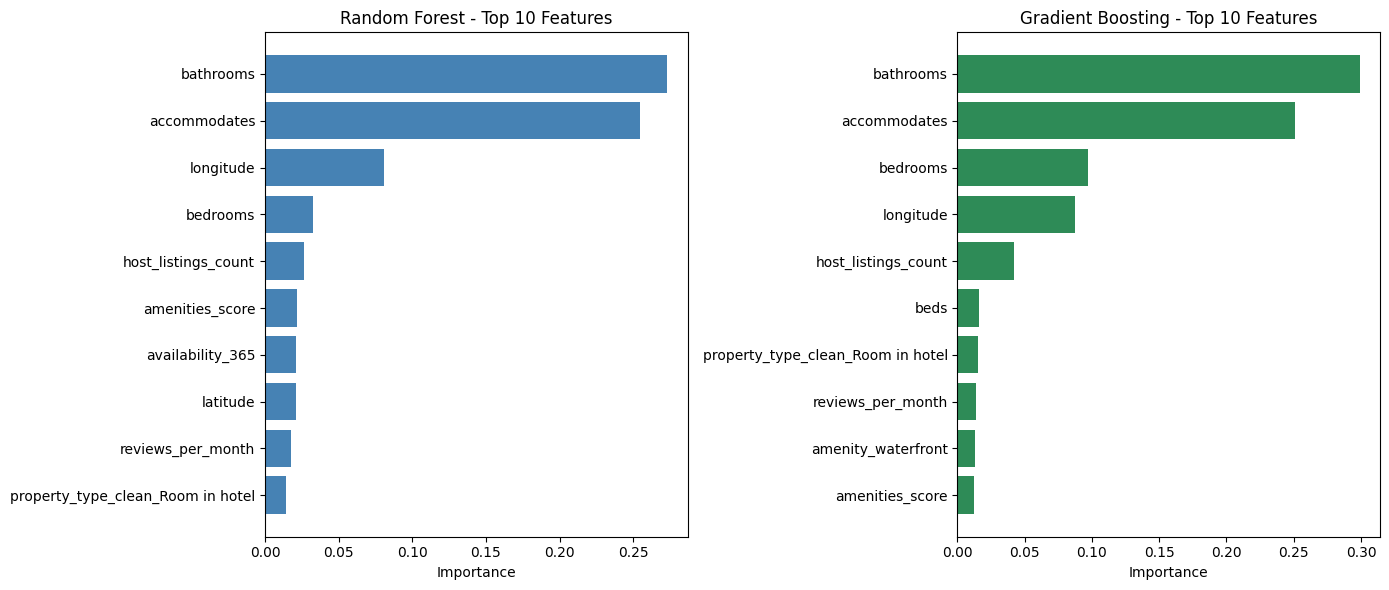

In [21]:
# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
ax1 = axes[0]
top10_rf = rf_importance.head(10)
ax1.barh(top10_rf['feature'], top10_rf['importance'], color='steelblue')
ax1.set_xlabel('Importance')
ax1.set_title('Random Forest - Top 10 Features')
ax1.invert_yaxis()

# Gradient Boosting
ax2 = axes[1]
top10_gbm = gbm_importance.head(10)
ax2.barh(top10_gbm['feature'], top10_gbm['importance'], color='seagreen')
ax2.set_xlabel('Importance')
ax2.set_title('Gradient Boosting - Top 10 Features')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# Top amenities
print("Top 10 Amenities (RF):")
print(rf_importance[rf_importance['feature'].str.startswith('amenity_')].head(10).to_string(index=False))

# Top neighborhoods
print("\nTop 10 Neighbourhoods (RF):")
print(rf_importance[rf_importance['feature'].str.startswith('neighbourhood_')].head(10).to_string(index=False))

Top 10 Amenities (RF):
                                      feature  importance
                           amenity_waterfront    0.006434
                              amenity_hot_tub    0.005011
                                 amenity_pool    0.004121
                           amenity_ocean_view    0.003532
              amenity_luggage_dropoff_allowed    0.002288
             amenity_free_parking_on_premises    0.002022
                         amenity_pets_allowed    0.001876
                     amenity_private_entrance    0.001810
amenity_exterior_security_cameras_on_property    0.001751
                                  amenity_gym    0.001661

Top 10 Neighbourhoods (RF):
                               feature  importance
       neighbourhood_cleansed_La Jolla    0.003903
neighbourhood_cleansed_Gaslamp Quarter    0.003167
   neighbourhood_cleansed_East Village    0.002311
  neighbourhood_cleansed_Pacific Beach    0.001740
    neighbourhood_cleansed_Mission Bay    0.001723
    

#### Feature Important/Amenity/Neighborhood Discussion
Based upon outputs above

### Neighborhood Discussion
- Initially I thought that in San Diego neighborhoods rather than lat/long would be more important to price, but while long (8%) and lat (2%) had some weight (see Randomforest list above), the neighborhoods had much less effect. Only for GBM 'neighbourhood_cleansed_La Jolla' had a weight of 1.08%
- For both RF and GBM, longitude appears in top 10 with 8+% importance, yet the only specific neighborhood to appear in either top 20 is La Jolla (GBM rank 12, 1.08%)
- Implies that the neighborhood dummies are redundant once you have lat/long coordinates
- perhaps reflects that San Diego is relatively homogeneous - wealthy coastal city without extreme variation

### Discussion: Feature Importance (RF vs Gradient Boosting)

**Shared Features**: Both models agree that 'bathrooms' and 'accommodates' are the two most important features by far, together accounting for ~53% (RF) and ~55% (GBM) of total feature importance. 'longitude', 'host_listings_count', 'bedrooms', 'reviews_per_month', 'amenities_score', and 'property_type_clean_Room in hotel' also appear in both top 10s (8 shared features total).


**Differences**:
- GBM concentrates importance more heavily in the top features, while RF variables have importance distributed more evenly. This reflects how GBM is built - sequentially, with each new tree focusing on what the previous one missed, so it tends to pick one feature from correlated   groups. RF builds independent trees in parallel, spreading importance across correlated features.
- 'bedrooms' ranks 3rd in GBM (9.75%) but only 4th in RF at 3.27% — GBM gives this variable much more weight

**Business implications**:
- Property fundamentals (bathrooms, capacity, bedrooms) are the primary price drivers
- Location matters — captured via coordinates (RF) or specific premium neighborhoods  like La Jolla (GBM) - but even La Jolla was less than longitude
- Premium amenities like waterfront access and hot tubs command higher prices

#### SHAP Analysis

In [23]:
# Train a CART model (single decision tree)
print("Training CART (Decision Tree)...")
start = time.time()

cart = DecisionTreeRegressor(max_depth=10, min_samples_leaf=20, random_state=42)
cart.fit(X_train, y_train)
y_pred_cart = cart.predict(X_test)

time_cart = time.time() - start

print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_cart)):.2f}")
print(f"  MAE: ${mean_absolute_error(y_test, y_pred_cart):.2f}")
print(f"  R²: {r2_score(y_test, y_pred_cart):.4f}")
print(f"  Time: {time_cart:.2f}s")

Training CART (Decision Tree)...
  RMSE: $188.58
  MAE: $105.14
  R²: 0.5489
  Time: 0.10s


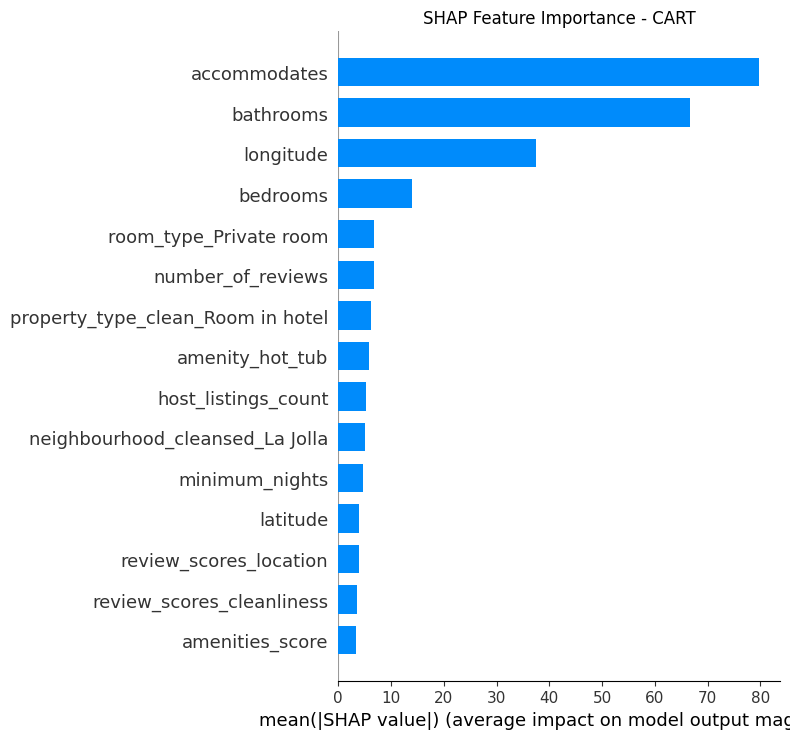

In [24]:
# SHAP for CART single tree
X_sample = X_train.sample(n=500, random_state=42)

explainer_cart = shap.TreeExplainer(cart)
shap_values_cart = explainer_cart.shap_values(X_sample)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_cart, X_sample, plot_type="bar", show=False, max_display=15)
plt.title("SHAP Feature Importance - CART")
plt.tight_layout()
plt.savefig('../outputs/shap_cart.png', dpi=150, bbox_inches='tight')
plt.show()

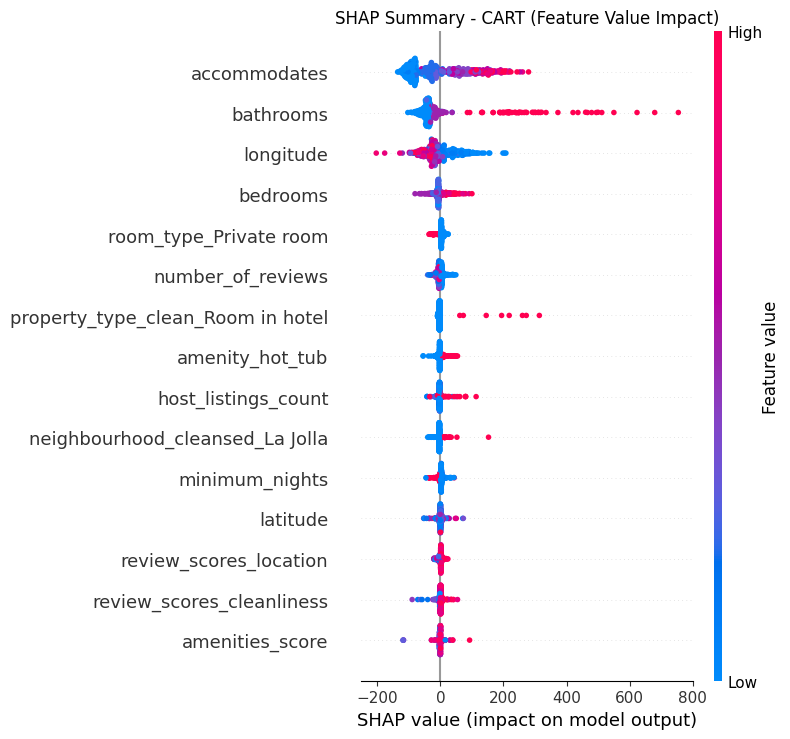

In [25]:
# Detailed SHAP summary: shows direction of effects
# Red = high feature value, Blue = low feature value
# Position on x-axis = impact on prediction
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_cart, X_sample, show=False, max_display=15)
plt.title("SHAP Summary - CART (Feature Value Impact)")
plt.tight_layout()
plt.savefig('../outputs/shap_cart_summary.png', dpi=150, bbox_inches='tight')
plt.show()

### SHAP Analysis Discussion

The SHAP summary plot reveals how feature values affect price predictions:

**Clear positive effects (high value → higher price):**
- **accommodates**: More guests (red) → significantly higher price
- **bathrooms**: More bathrooms (red) → higher price
- **bedrooms**: More bedrooms (red) → higher price
- **amenity_hot_tub**: Having a hot tub (red=1)
- 
**Clear negative effects (high value → lower price):**
- **room_type_Private room**: Being a private room (red=1) → lower price (-$100)
- **longitude**: Higher longitude (more east in San Diego, away from beach) → lower price

**Location insights:**
- **neighbourhood_cleansed_La Jolla**: Being in La Jolla (red=1) → +$50-150 premium
- **latitude/longitude**: Captures coastal premium (west/beach locations)

This dovetails nicely with our obversations above that property size (accommodates, bathrooms, bedrooms) and location (La Jolla, longitude) are the primary price drivers, with premium amenities (hot tub) adding clear value.

---

## Part II: Validity

### 5. Prepare Validation Datasets

In [26]:
# load validation datasets
df_raw_sd_q3 = pd.read_csv('../data/San Diego 2025 Q3 listings.csv')
df_raw_broward = pd.read_csv('../data/Broward County 2025 Q3 listings.csv')

print(f"San Diego Q3 2025: {df_raw_sd_q3.shape}")
print(f"Broward County Q3 2025: {df_raw_broward.shape}")

San Diego Q3 2025: (13162, 79)
Broward County Q3 2025: (16822, 79)


In [27]:
# datewrangling validation datasets using same amenities_list from training
df_val_SD_time, _ = wrangle_airbnb_data(df_raw_sd_q3, price_upper_bound=price_upper_bound, amenities_list=amenities_list)
df_val_BC_geo, _ = wrangle_airbnb_data(df_raw_broward, price_upper_bound=price_upper_bound, amenities_list=amenities_list)

print(f"San Diego Q3 2025 after wrangling: {df_val_SD_time.shape}")
print(f"Broward County Q3 2025 after wrangling: {df_val_BC_geo.shape}")

San Diego Q3 2025 after wrangling: (11223, 73)
Broward County Q3 2025 after wrangling: (11605, 73)


In [28]:
# Create dummies for validation sets, as above for training set
cat_cols = df_val_SD_time.select_dtypes(include=['object']).columns.tolist()
df_val_SD_time_model = pd.get_dummies(df_val_SD_time, columns=cat_cols, drop_first=True)
df_val_SD_time_model[df_val_SD_time_model.select_dtypes(include=['bool']).columns] = df_val_SD_time_model.select_dtypes(include=['bool']).astype(int)

cat_cols = df_val_BC_geo.select_dtypes(include=['object']).columns.tolist()
df_val_BC_geo_model = pd.get_dummies(df_val_BC_geo, columns=cat_cols, drop_first=True)
df_val_BC_geo_model[df_val_BC_geo_model.select_dtypes(include=['bool']).columns] = df_val_BC_geo_model.select_dtypes(include=['bool']).astype(int)

print(f"San Diego Q3 2025 with dummies: {df_val_SD_time_model.shape}")
print(f"Broward County Q3 2025 with dummies: {df_val_BC_geo_model.shape}")

San Diego Q3 2025 with dummies: (11223, 184)
Broward County Q3 2025 with dummies: (11605, 116)


In [29]:
# Function to ensure validation data has same columns as training data
def align_to_training(df_val, train_columns):
    """Add missing columns (as 0), drop extra columns"""
    df = df_val.copy()
    
    # Add missing columns
    for col in train_columns:
        if col not in df.columns:
            df[col] = 0
    
    # Keep only training columns (in same order)
    return df[train_columns]


In [30]:

# Get training feature columns (excluding id and price)
train_feature_cols = [c for c in df_train_model.columns if c not in ['id', 'price']]

# Align validation sets - so both new datasets have same features as training, despite different dummies created due to 
# different categories in new data (for neighborhoods)
X_val_SD_time = align_to_training(df_val_SD_time_model, train_feature_cols)
y_val_SD_time = df_val_SD_time_model['price']

X_val_BC_geo = align_to_training(df_val_BC_geo_model, train_feature_cols)
y_val_BC_geo = df_val_BC_geo_model['price']

print(f"X_val_SD_time: {X_val_SD_time.shape}")
print(f"X_val_BC_geo: {X_val_BC_geo.shape}")
print(f"Training features: {len(train_feature_cols)}")

X_val_SD_time: (11223, 181)
X_val_BC_geo: (11605, 181)
Training features: 181


In [31]:
#just want to compare what columns are missing/extra in Broward compared to training set, see what was removed/added

# Training columns
print(f"Training columns: {len(train_feature_cols)}")
print(train_feature_cols[:20])  # first 20

# Check what Broward is missing (SD neighborhoods)
missing_in_broward = set(train_feature_cols) - set(df_val_BC_geo_model.columns)
print(f"\nColumns added to Broward (as 0s): {len(missing_in_broward)}")
print(list(missing_in_broward)[:20])

# Check what Broward has extra (Broward neighborhoods)
extra_in_broward = set(df_val_BC_geo_model.columns) - set(train_feature_cols) - {'id', 'price'}
print(f"\nColumns dropped from Broward: {len(extra_in_broward)}")
print(list(extra_in_broward)[:20])

Training columns: 181
['accommodates', 'bedrooms', 'beds', 'latitude', 'longitude', 'host_is_superhost', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_identity_verified', 'number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'availability_30', 'availability_365', 'instant_bookable', 'minimum_nights']

Columns added to Broward (as 0s): 102
['neighbourhood_cleansed_Amphitheater And Water Park', 'neighbourhood_cleansed_Tierrasanta', 'neighbourhood_cleansed_Mission Bay', 'neighbourhood_cleansed_Sky Line', 'neighbourhood_cleansed_Midtown District', 'neighbourhood_cleansed_Estlake Greens', 'neighbourhood_cleansed_Cortez Hill', 'neighbourhood_cleansed_Mountain View', 'neighbourhood_cleansed_Paradise Hills', 'neighbourhood_cleansed_Mission Valley', 'neighbourhood_cleansed_Northwest', 'neighbourhood_cleansed_Chollas View', 'neighbourhood_cleansed_Normal Heights', 'neighbourhood

In [32]:
# Scale validation data for LASSO
X_val_SD_time_scaled = scaler.transform(X_val_SD_time)
X_val_BC_geo_scaled = scaler.transform(X_val_BC_geo)

# Predict with all 5 models on both validation datasets
#  Apply trained models to both validation sets (no retraining)
val_results = {}

for name, model, X_sd, X_bc in [
    ('OLS', ols, X_val_SD_time, X_val_BC_geo),
    ('LASSO', lasso, X_val_SD_time_scaled, X_val_BC_geo_scaled),
    ('Random Forest', rf, X_val_SD_time, X_val_BC_geo),
    ('Gradient Boosting', gbm, X_val_SD_time, X_val_BC_geo),
    ('XGBoost', xgb_model, X_val_SD_time, X_val_BC_geo),
]:
    y_pred_sd = model.predict(X_sd)
    y_pred_bc = model.predict(X_bc)
    
    val_results[name] = {
        'SD_Q3_RMSE': np.sqrt(mean_squared_error(y_val_SD_time, y_pred_sd)),
        'SD_Q3_R2': r2_score(y_val_SD_time, y_pred_sd),
        'BC_RMSE': np.sqrt(mean_squared_error(y_val_BC_geo, y_pred_bc)),
        'BC_R2': r2_score(y_val_BC_geo, y_pred_bc),
    }

val_table = pd.DataFrame(val_results).T

In [33]:
# Combined horserace: Training vs Validation
# - Training: San Diego Q4 2024
# - Temporal Validation: San Diego Q3 2025 (same city, later date)
# - Geographic Validation: Broward County Q3 2025 (different city)

combined = pd.DataFrame({
    'Train_RMSE': [results['OLS']['RMSE'], results['LASSO']['RMSE'], results['Random Forest']['RMSE'], 
                   results['Gradient Boosting']['RMSE'], results['XGBoost']['RMSE']],
    'Train_R2': [results['OLS']['R2'], results['LASSO']['R2'], results['Random Forest']['R2'],
                 results['Gradient Boosting']['R2'], results['XGBoost']['R2']],
    'Temporal_RMSE': val_table['SD_Q3_RMSE'],
    'Temporal_R2': val_table['SD_Q3_R2'],
    'Geo_RMSE': val_table['BC_RMSE'],
    'Geo_R2': val_table['BC_R2'],
}, index=['OLS', 'LASSO', 'Random Forest', 'Gradient Boosting', 'XGBoost'])

print("=" * 100)
print("VALIDATION HORSERACE")
print("  Train = San Diego Q4 2024 | Temporal = San Diego Q3 2025 | Geo = Broward County Q3 2025")
print("=" * 100)
print(combined.round(2).to_string())
print("=" * 100)

VALIDATION HORSERACE
  Train = San Diego Q4 2024 | Temporal = San Diego Q3 2025 | Geo = Broward County Q3 2025
                   Train_RMSE  Train_R2  Temporal_RMSE  Temporal_R2  Geo_RMSE    Geo_R2
OLS                    171.43      0.63         160.05         0.51  21584.59 -15390.84
LASSO                  171.48      0.63         159.87         0.51  22852.40 -17252.08
Random Forest          156.32      0.69         146.73         0.59    147.19      0.28
Gradient Boosting      150.42      0.71         152.87         0.55    145.13      0.30
XGBoost                158.54      0.68         154.91         0.54    161.42      0.14


### Validation Discussion

**Temporal Validation (San Diego Q3 2025):**
- All models generalize reasonably well to the same city 9 to 12 months later
- RMSE actually improved slightly ($147-155 vs $157-171 in training)
- R^2 dropped from approx 0.63-0.72 to approx 0.51-0.59, suggesting market changes over time
- Random Forest now performs best on temporal validation (RMSE $146.73, R^2 0.59)

**Geographic Validation (Broward County Q3 2025):**
- **Linear models (OLS, LASSO) extremely poor** - RMSE of $21,000+ and negative R^2
- **Tree-based models survive** - RMSE $145-161, R^2 0.14-0.30
- GBM best on geographic validation (RMSE $145.13, R^2 0.30)

**Why did linear models fail for Broward County?**
- OLS/LASSO learned coefficients for San Diego neighborhoods and lat/long
- When applied to Broward (all SD neighborhood dummies = 0, completely different lat/long), they extrapolate wildly
- All of the San Diego neighborhood dummies contribute nothing; the model relies on broken geographic assumptions

**Why did tree models survive?**
- Trees learn conditional rules ("if bathrooms > 2 AND accommodates > 4, predict higher price")
- These property-based rules transfer across cities


**Business Implication:**
- For same-city pricing: Random Forest recommended - best temporal validation (R^2 0.53) despite slightly lower training fit
- Gradient Boosting has highest training R^2 (0.71) but may be slightly overfitting
- For expanding to new markets: Random Forest recommended (best Geo R^2 0.24), and consider retraining on local data
- As most Airbnb hosts initially stick to a single market, this makes operational sense as well - retrain your model once you expand